In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
!pip install -U torch torchvision diffusers transformers accelerate DeepCache tgate pytorch-fid

# main lib
!git clone https://github.com/philurame/diffusion_speedup.git

# CLIP
!pip install -U git+https://github.com/openai/CLIP.git

# coco API
!pip install -U scikit-image
!pip install -U cython
!pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

# DeepCache vs T-Gate vs Both vs None

In [ ]:
from diffusion_speedup.SDclass import SDCompare
from diffusers import DPMSolverMultistepScheduler
scheduler_dict = dict(
  scheduler = DPMSolverMultistepScheduler,
  params = {}
)

sd = SDCompare(scheduler_dict, cache_model='deepcache', model='SD')

In [98]:
list_inference_steps = [5,15,25]

sd.init_cacher(None)
res_both = sd.STATS(list_inference_steps)

sd.init_cacher('deepcache')
res_deepcache = sd.STATS(list_inference_steps)

sd.init_cacher('tgate')
res_tgate = sd.STATS(list_inference_steps)

sd.init_cacher('both')
res_both = sd.STATS(list_inference_steps)

# Inference Steps      TFlops          Clip            FID       
# ----------------------------------------------------------------
# 5                    13.393          0.284           None      
# 15                   20.27           0.306           None      
# 25                   27.147          0.31            None      

CLIP: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [05:18<00:00,  1.61it/s]


Inference Steps      TFlops          Clip Mean       FID       
----------------------------------------------------------------
5                    13.393          0.284           None      
15                   20.27           0.306           None      
25                   27.147          0.31            None      


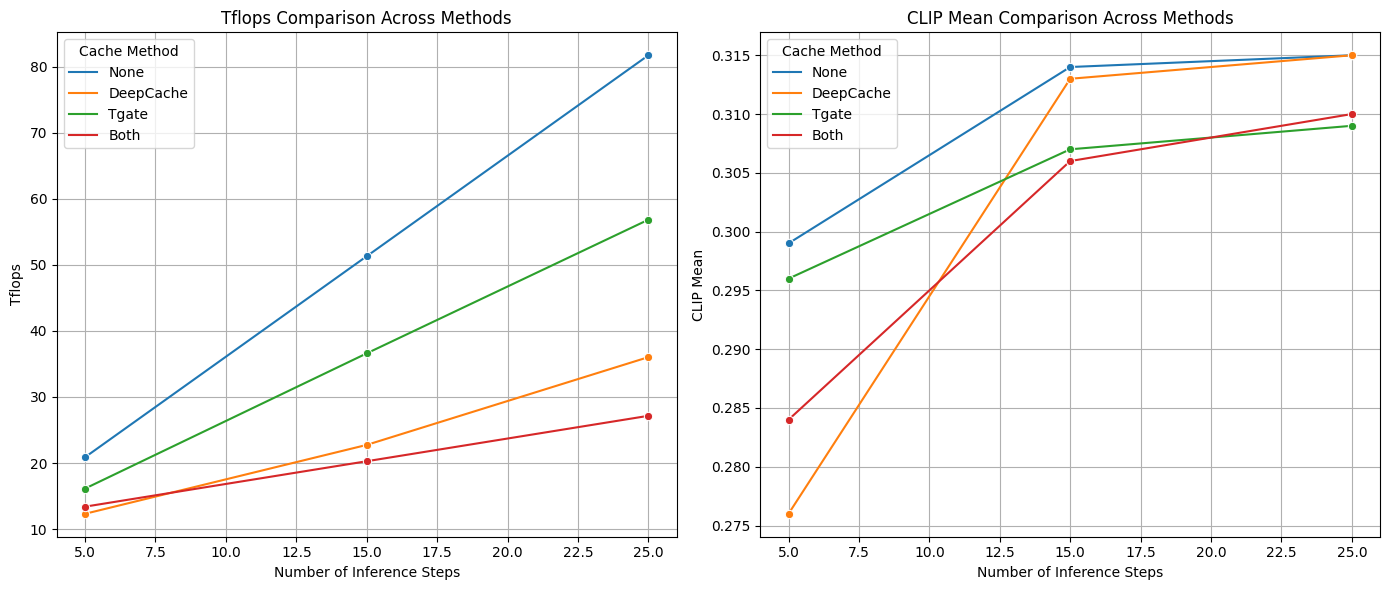

In [120]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {
  'num_inference_steps': list_inference_steps * 4,
  'Tflops': res_None[0] + res_deepcache[0] + res_tgate[0] + res_both[0],
  'Clip_mean': res_None[1] + res_deepcache[1] + res_tgate[1] + res_both[1],
  'Cache Method': ['None'] * len(list_inference_steps) +
                  ['DeepCache'] * len(list_inference_steps) +
                  ['Tgate'] * len(list_inference_steps) +
                  ['Both'] * len(list_inference_steps)
}
df = pd.DataFrame(data)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Tflops
sns.lineplot(x='num_inference_steps', y='Tflops', hue='Cache Method', data=df, marker='o', ax=axes[0])
axes[0].set_title('Tflops Comparison Across Methods')
axes[0].set_ylabel('Tflops')
axes[0].set_xlabel('Number of Inference Steps')
axes[0].grid(True)

# Plot Clip_mean
sns.lineplot(x='num_inference_steps', y='Clip_mean', hue='Cache Method', data=df, marker='o', ax=axes[1])
axes[1].set_title('CLIP Mean Comparison Across Methods')
axes[1].set_ylabel('CLIP Mean')
axes[1].set_xlabel('Number of Inference Steps')
axes[1].grid(True)

plt.tight_layout()
plt.show()

- we'll use DeepCache because T-GATE isn't really helpful here (nor in BOTH cache method) 

# DPMSolvers Comparison

In [52]:
import gc, torch
from joblib import Parallel, delayed
from IPython.utils.io import capture_output
from tqdm import tqdm

from diffusers import DPMSolverMultistepScheduler

def run_sd_on_device(device, scheduler_dict):
  list_inference_steps = [5, 15, 25, 50]
  sd = SDCompare(scheduler_dict, cache_model='deepcache', model='SD', device=torch.device(device), verbose=False)
  return sd.STATS(list_inference_steps)[:2]

schedulers = [
  dict(
    scheduler = DPMSolverMultistepScheduler,
    params = dict(algorithm_type=f'{j}dpmsolver++', solver_order=i, use_karras_sigmas=k),
  ) 
  for i in [1,2] for j in ['', 'sde-'] for k in [True, False]
]

results_dpmsolv = []
mum_GPUs = 4
for i in tqdm(range(0, len(schedulers), mum_GPUs)):
  batch_schedulers = schedulers[i:i + mum_GPUs]
  devices = [f'cuda:{i % mum_GPUs}' for i in range(mum_GPUs)]
  
  torch.cuda.empty_cache()
  gc.collect()
  
  results_batch = Parallel(n_jobs=len(devices), backend='loky', timeout=99999)(delayed(run_sd_on_device)(device, scheduler) for device, scheduler in zip(devices, batch_schedulers))
  results_dpmsolv.extend(results_batch)

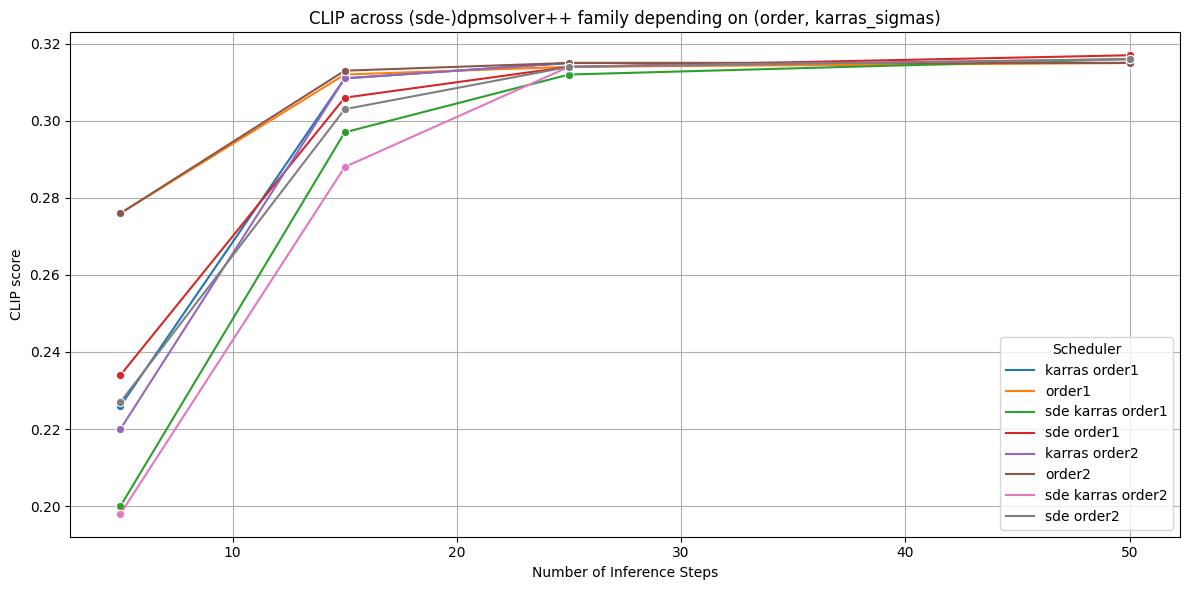

In [53]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

scheduler_names = [f'{j}{k}order{i}' for i in [1,2] for j in ['', 'sde '] for k in ['karras ', '']]
data = {
  'num_inference_steps': [5, 15, 25, 50] * len(scheduler_names),
  'CLIP': [stat for sched_res in results_dpmsolv for stat in sched_res[1]],
  'Scheduler': [name for name in scheduler_names for _ in range(4)],
}
df = pd.DataFrame(data)

fig, axes = plt.subplots(figsize=(12, 6))

# Plot Clip_mean
sns.lineplot(x='num_inference_steps', y='CLIP', hue='Scheduler', data=df, marker='o', ax=axes)
axes.set_title('CLIP across (sde-)dpmsolver++ family depending on (order, karras_sigmas)')
axes.set_ylabel('CLIP score')
axes.set_xlabel('Number of Inference Steps')
axes.grid(True)
plt.tight_layout()
plt.show()

In [55]:
df[df['Scheduler']=='order2']

,num_inference_steps,CLIP,Scheduler
20,5,0.276,order2
21,15,0.313,order2
22,25,0.315,order2
23,50,0.315,order2


- here the best is ddpmsolver++ of orders 1 (which is equal to DDIM) and 2

# EDMSolvers Comparison

In [ ]:
from tqdm import tqdm
from IPython.utils.io import capture_output
import gc, torch
from joblib import Parallel, delayed
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

from diffusers import HeunDiscreteScheduler, EulerDiscreteScheduler

def run_sd_on_device(device, scheduler_dict):
  if scheduler_dict['scheduler'] == 'EulerDiscreteScheduler':
    step_params = scheduler_dict['params'].copy()
    class ParamEulerDiscreteScheduler(EulerDiscreteScheduler):
      def step(self, *args, **kwargs):
        kwargs.update(step_params)
        return EulerDiscreteScheduler.step(self, *args, **kwargs)
    scheduler_dict = {'scheduler': ParamEulerDiscreteScheduler, 'params': {}}
  
  list_inference_steps = [5, 15, 25, 50]
  sd = SDCompare(scheduler_dict, cache_model='deepcache', model='SD', device=torch.device(device), verbose=False)
  return sd.STATS(list_inference_steps)[:2]

schedulers = [dict(scheduler = HeunDiscreteScheduler, params = {}) ] + \
[
  dict(scheduler = 'EulerDiscreteScheduler',
    params = dict(s_churn=s_churn, s_tmin=s_tmin, s_tmax=s_tmax, s_noise=s_noise)
  )
  for s_churn in [30, 80] for s_tmin in [0.01, 0.05] for s_tmax in [1, 50] for s_noise in [1.003, 1.007]
]

results_edm = []
mum_GPUs = 4
for i in tqdm(range(0, len(schedulers), mum_GPUs)):
  batch_schedulers = schedulers[i:i + mum_GPUs]
  devices = [f'cuda:{i % mum_GPUs}' for i in range(len(batch_schedulers))]
  
  torch.cuda.empty_cache()
  gc.collect()

  results_batch = Parallel(n_jobs=len(devices), backend='loky', timeout=99999)(delayed(run_sd_on_device)(device, scheduler) for device, scheduler in zip(devices, batch_schedulers))
  results_edm.extend(results_batch)

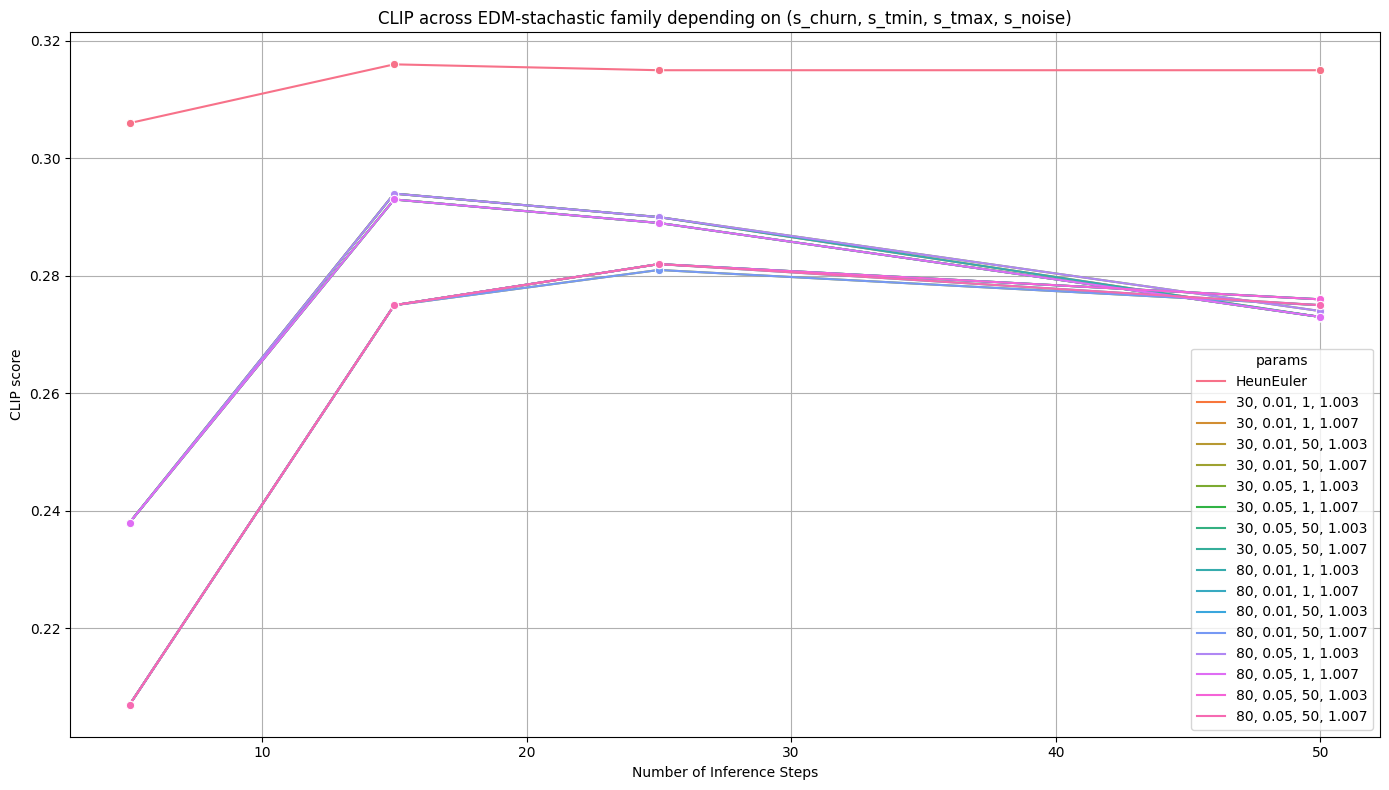

In [50]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

scheduler_names = ['HeunEuler'] + \
  [f'{s_churn}, {s_tmin}, {s_tmax}, {s_noise}' for s_churn in [30, 80] for s_tmin in [0.01, 0.05] for s_tmax in [1, 50] for s_noise in [1.003, 1.007]]
data = {
  'num_inference_steps': [5, 15, 25, 50] * len(scheduler_names),
  'CLIP': [stat for sched_res in results_edm for stat in sched_res[1]],
  'params': [name for name in scheduler_names for _ in range(4)],
}
df = pd.DataFrame(data)

fig, axes = plt.subplots(figsize=(14, 8))

# Plot Clip_mean
sns.lineplot(x='num_inference_steps', y='CLIP', hue='params', data=df, marker='o', ax=axes)
axes.set_title('CLIP across EDM-stachastic family depending on (s_churn, s_tmin, s_tmax, s_noise)')
axes.set_ylabel('CLIP score')
axes.set_xlabel('Number of Inference Steps')
axes.grid(True)
plt.tight_layout()
plt.show()

In [52]:
df[df['params']=='HeunEuler']

,num_inference_steps,CLIP,params
0,5,0.306,HeunEuler
1,15,0.316,HeunEuler
2,25,0.315,HeunEuler
3,50,0.315,HeunEuler


# PNDM, UniPC, TCD

In [ ]:
import gc, torch
from joblib import Parallel, delayed
from IPython.utils.io import capture_output
from tqdm import tqdm

from diffusers import PNDMScheduler, UniPCMultistepScheduler, TCDScheduler

def run_sd_on_device(device, scheduler_dict):
  list_inference_steps = [5, 15, 25, 50]
  sd = SDCompare(scheduler_dict, cache_model='deepcache', model='SD', device=torch.device(device), verbose=False)
  return sd.STATS(list_inference_steps)[:2]

schedulers = [
  dict(scheduler = PNDMScheduler, params = {'skip_prk_steps': True}), 
  dict(scheduler = TCDScheduler,  params = {}),
  ] + \
  [dict(scheduler = UniPCMultistepScheduler, params = {'solver_order': i}) for i in [1, 2, 3]]

results_others = []
mum_GPUs = 4
for i in tqdm(range(0, len(schedulers), mum_GPUs)):
  batch_schedulers = schedulers[i:i + mum_GPUs]
  devices = [f'cuda:{i % mum_GPUs}' for i in range(mum_GPUs)]
  
  torch.cuda.empty_cache()
  gc.collect()
  
  results_batch = Parallel(n_jobs=len(devices), backend='loky')(delayed(run_sd_on_device)(device, scheduler) for device, scheduler in zip(devices, batch_schedulers))
  results_others.extend(results_batch)

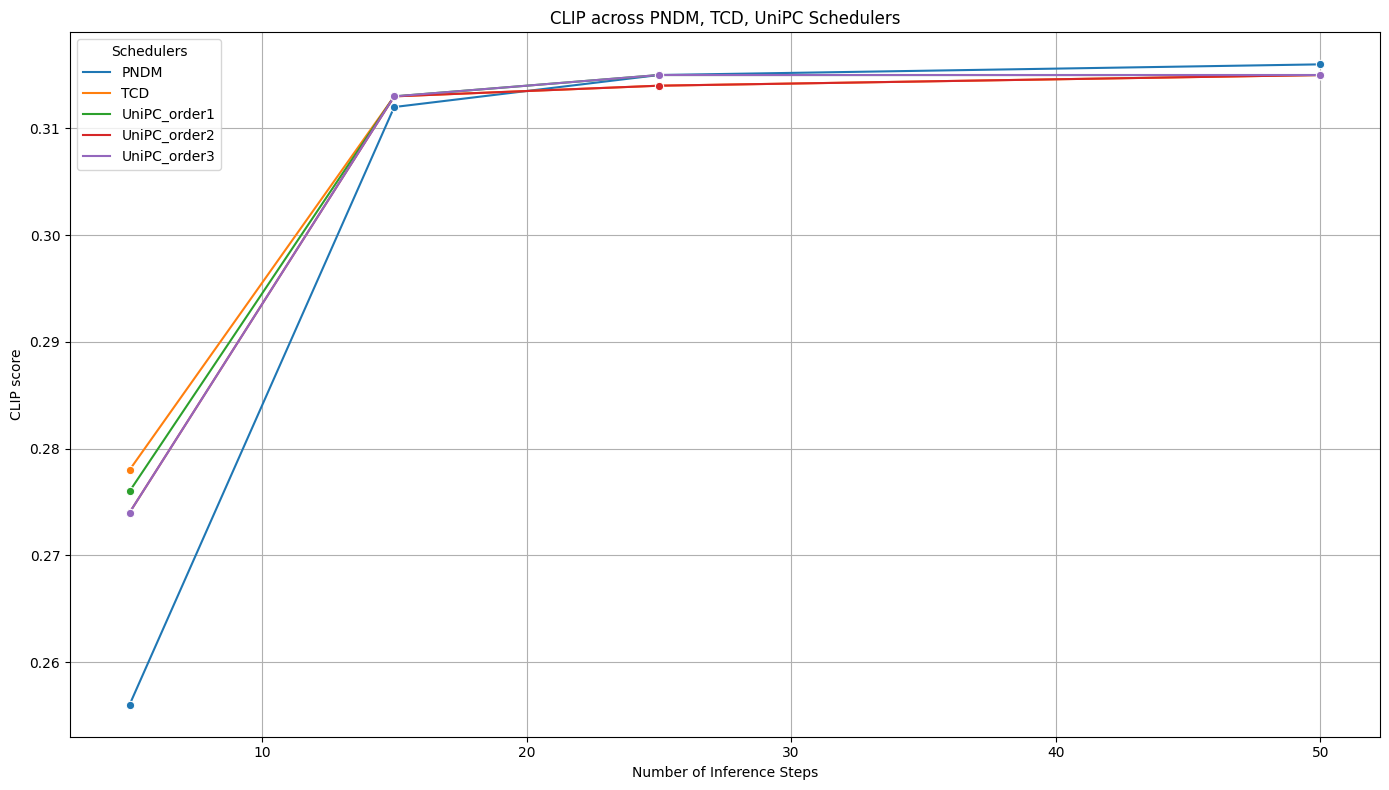

In [14]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

scheduler_names = ['PNDM', 'TCD'] + [f'UniPC_order{i}' for i in [1,2,3]]
data = {
  'num_inference_steps': [5, 15, 25, 50] * len(scheduler_names),
  'CLIP': [stat for sched_res in results_others for stat in sched_res[1]],
  'Schedulers': [name for name in scheduler_names for _ in range(4)],
}
df = pd.DataFrame(data)

fig, axes = plt.subplots(figsize=(14, 8))

# Plot Clip_mean
sns.lineplot(x='num_inference_steps', y='CLIP', hue='Schedulers', data=df, marker='o', ax=axes)
axes.set_title('CLIP across PNDM, TCD, UniPC Schedulers')
axes.set_ylabel('CLIP score')
axes.set_xlabel('Number of Inference Steps')
axes.grid(True)
plt.tight_layout()
plt.show()

In [20]:
df.query('Schedulers in ["PNDM", "TCD"]')

,num_inference_steps,CLIP,Schedulers
0,5,0.256,PNDM
1,15,0.312,PNDM
2,25,0.315,PNDM
3,50,0.316,PNDM
4,5,0.278,TCD
5,15,0.313,TCD
6,25,0.314,TCD
7,50,0.315,TCD


# Extended FID and CLIP for DPMSolver++(2), EDM(HeunEuler) and PNDM, with possible AYS

In [3]:
from diffusion_speedup.SDclass import SDCompare
from diffusers import DPMSolverMultistepScheduler
scheduler_dict = dict(scheduler = DPMSolverMultistepScheduler)
sd = SDCompare(scheduler_dict, cache_model='deepcache', model='SD', verbose=False, N_clip=512, N_fid=8192, use_coco_imgs=True)

resizing imgs: 100%|██████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:00<00:00, 61199.74it/s]


In [355]:
from tqdm import tqdm
import numpy as np
from IPython.utils.io import capture_output
import gc, torch
from joblib import Parallel, delayed
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

from diffusers import HeunDiscreteScheduler, PNDMScheduler, DPMSolverMultistepScheduler

def loglinear_interp_AYS(model, num_steps):
  """
  Performs log-linear interpolation of a given array of decreasing numbers.
  """
  if model == 'SD':
    timesteps_10 = [999, 850, 736, 645, 545, 455, 343, 233, 124, 24]
  elif model == 'SDXL':
    timesteps_10 = [999, 845, 730, 587, 443, 310, 193, 116, 53, 13]

  xs = np.linspace(0, 1, len(timesteps_10))
  ys = np.log(timesteps_10[::-1])
  new_xs = np.linspace(0, 1, num_steps)
  new_ys = np.interp(new_xs, xs, ys)
  interped_ys = np.exp(new_ys)[::-1].copy()
  return list(map(round, interped_ys))+[0]


def run_sd_on_device(device, scheduler_dict):
  list_inference_steps = [4, 10, 30, 60, 100]
  
  timesteps = []
  if scheduler_dict['params'].pop('AYS', False):
    timesteps = [{'timesteps': loglinear_interp_AYS('SD', step)} for step in list_inference_steps]

  sd = SDCompare(scheduler_dict, cache_model='deepcache', model='SD', device=torch.device(device),  N_clip=512, N_fid=4096)
  sd.use_coco_imgs = True
  return sd.STATS(list_inference_steps, get_fid=True, pipe_kwargs_list=timesteps)[1:]

schedulers = [
  dict(scheduler = DPMSolverMultistepScheduler, params = {'AYS':True}, name='dpmA'),
  dict(scheduler = HeunDiscreteScheduler,       params = {'AYS':True}, name='heuA'),
  dict(scheduler = DPMSolverMultistepScheduler, params = {'AYS':False}, name='dpm'),
  dict(scheduler = HeunDiscreteScheduler,       params = {'AYS':False}, name='heu'),
  dict(scheduler = PNDMScheduler,               params = {'skip_prk_steps':True}, name='pndS'),
  dict(scheduler = PNDMScheduler,               params = {'skip_prk_steps':False}, name='pnd'),
] 

results_best = []
mum_GPUs = 4
for i in tqdm(range(0, len(schedulers), mum_GPUs)):
  batch_schedulers = schedulers[i:i + mum_GPUs]
  devices = [f'cuda:{i % mum_GPUs}' for i in range(len(batch_schedulers))]
  
  torch.cuda.empty_cache()
  gc.collect()

  results_batch = Parallel(n_jobs=len(devices), backend='loky', timeout=99999)(delayed(run_sd_on_device)(device, scheduler) for device, scheduler in zip(devices, batch_schedulers))
  results_best.extend(results_batch)

FID_10:  12%|█▏        | 498/4096 [03:47<27:29,  2.18it/s]]

In [ ]:
results_best

In [ ]:
!rm -r image_data/imgs_SD

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

scheduler_names = ['DPM+AYS', 'HeunEuler+AYS', 'PNDM_skip', 'DPM', 'HeunEuler', 'PNDM']
data = {
  'num_inference_steps': [4, 10, 30, 60, 100] * len(scheduler_names),
  'CLIP': [stat for sched_res in results_best for stat in sched_res[0]],
  'FID': [stat for sched_res in results_best for stat in sched_res[1]],
  'Schedulers': [name for name in scheduler_names for _ in range(5)],
}
df = pd.DataFrame(data)

fig, axes = plt.subplots(1,2, figsize=(18, 8))

# Plot Clip
sns.lineplot(x='num_inference_steps', y='CLIP', hue='Schedulers', data=df, marker='o', ax=axes[0])
axes[0].set_title('CLIP across DPMSolver++(2), EDM(HEUN), PNDM Schedulers')
axes[0].set_ylabel('CLIP score')
axes[0].set_xlabel('Number of Inference Steps')
axes[0].grid(True)

# Plot FID
sns.lineplot(x='num_inference_steps', y='FID', hue='Schedulers', data=df, marker='o', ax=axes[1])
axes[1].set_title('FID across DPMSolver++(2), EDM(HEUN), PNDM Schedulers')
axes[1].set_ylabel('FID score')
axes[1].set_xlabel('Number of Inference Steps')
axes[1].grid(True)

plt.tight_layout()
plt.show()